# Text Classification for Scientific Articles

This notebook implements a comprehensive text classification system to categorize scientific articles based on their title and abstract into predefined groups.

## Overview
- Data exploration and preprocessing
- N-gram analysis and word frequency
- Stopwords analysis and customization
- Baseline model implementation
- Hyperparameter optimization
- Model evaluation and comparison

In [1]:
pip install -r requirements_text_classification.txt

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached jupyterlab-4.4.5-py3-none-any.whl.metadata (16 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jupyter_lsp-2.2.6-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.16.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyterlab_server-2.27.3-py3-non

In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Download required NLTK data
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
except:
    print("NLTK data already available")

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniela.diazgranados/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniela.diazgranados/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daniela.diazgranados/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daniela.diazgranados/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Data Loading and Exploration

In [32]:
# Load the dataset
df = pd.read_csv('../data/challenge_data.csv', sep=';')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (3565, 3)

Columns: ['title', 'abstract', 'group']

First few rows:


,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological


Missing values:
title       0
abstract    0
group       0
dtype: int64

Unique groups and counts:
group
neurological                                           1058
cardiovascular                                          645
hepatorenal                                             533
neurological|cardiovascular                             308
oncological                                             237
neurological|hepatorenal                                202
cardiovascular|hepatorenal                              190
neurological|oncological                                143
hepatorenal|oncological                                  98
cardiovascular|oncological                               70
neurological|cardiovascular|hepatorenal                  28
neurological|hepatorenal|oncological                     26
neurological|cardiovascular|oncological                  13
cardiovascular|hepatorenal|oncological                    7
neurological|cardiovascular|hepatorenal|oncological     

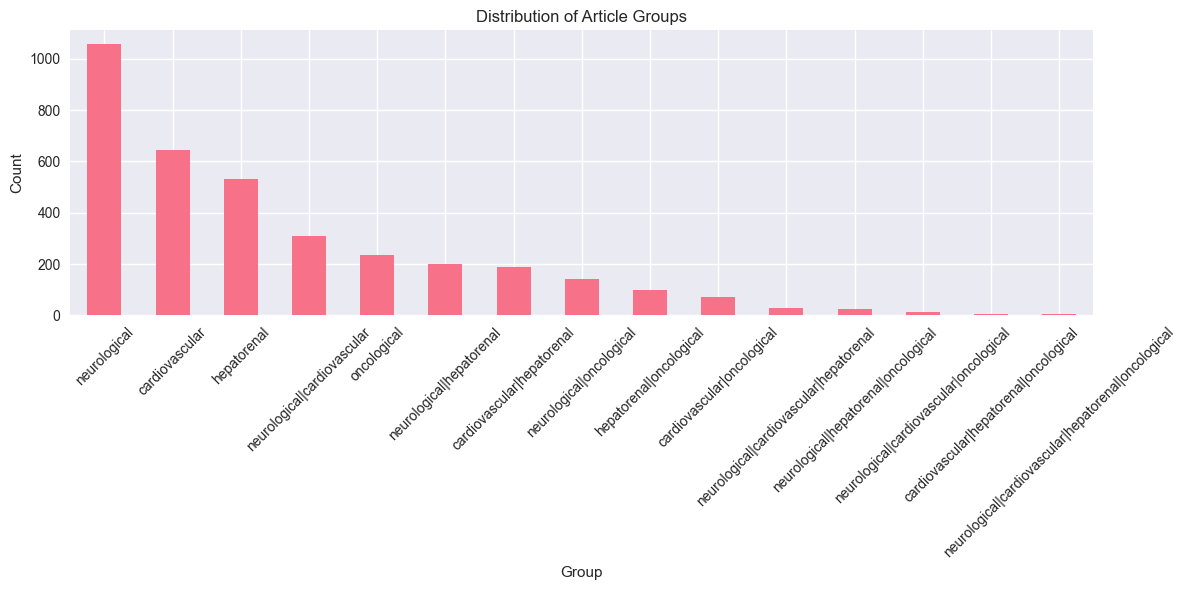

In [33]:
# Check for missing values
print("Missing values:")
print(df[['title', 'abstract', 'group']].isnull().sum())

# Display unique groups and their counts
print("\nUnique groups and counts:")
group_counts = df['group'].value_counts()
print(group_counts)

# Visualize group distribution
plt.figure(figsize=(12, 6))
group_counts.plot(kind='bar')
plt.title('Distribution of Article Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Text Analysis and N-gram Exploration

Text length statistics:
       text_length   word_count
count  3565.000000  3565.000000
mean    766.890603   108.785694
std     606.648725    96.624001
min     227.000000    28.000000
25%     318.000000    37.000000
50%     361.000000    43.000000
75%    1232.000000   185.000000
max    3907.000000   535.000000


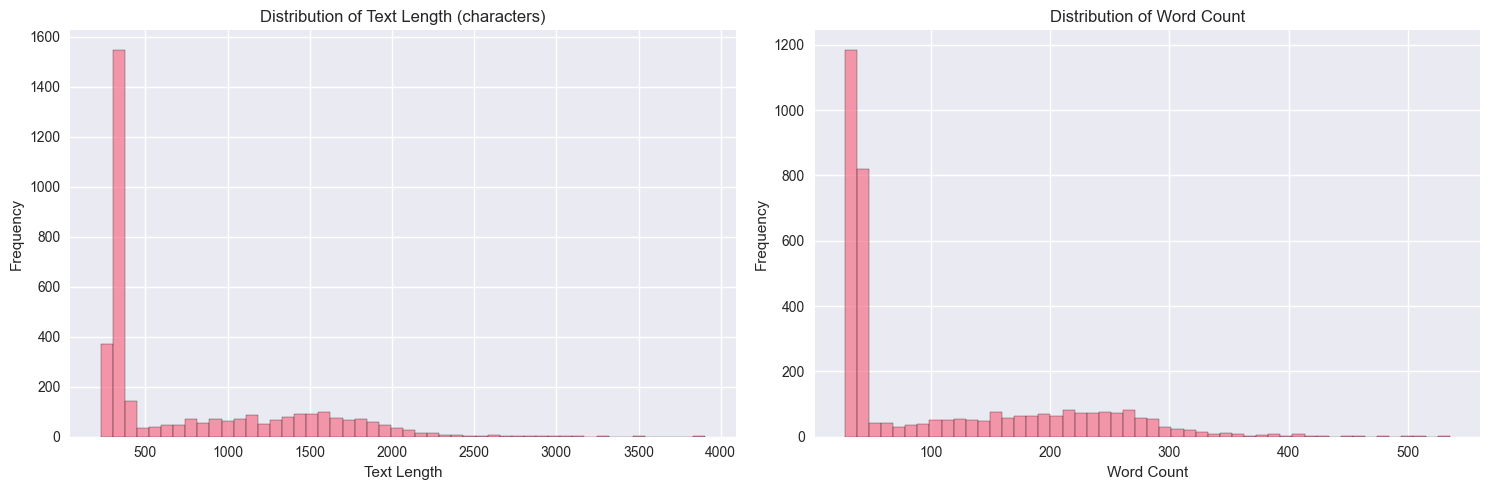

In [34]:
# Combine title and abstract for analysis
df['combined_text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

# Basic text statistics
df['text_length'] = df['combined_text'].str.len()
df['word_count'] = df['combined_text'].str.split().str.len()

print("Text length statistics:")
print(df[['text_length', 'word_count']].describe())

# Visualize text length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_title('Distribution of Text Length (characters)')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')

ax2.hist(df['word_count'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Word Count')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
# Function to extract and analyze n-grams
def analyze_ngrams(texts, n=1, top_k=20):
    """Analyze n-grams in a list of texts"""
    all_ngrams = []
    
    for text in texts:
        if pd.isna(text) or text == '':
            continue
        
        # Tokenize and clean
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalnum()]
        
        # Generate n-grams
        if n == 1:
            ngram_list = tokens
        else:
            ngram_list = list(ngrams(tokens, n))
            ngram_list = [' '.join(gram) for gram in ngram_list]
        
        all_ngrams.extend(ngram_list)
    
    # Count frequencies
    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_k)

# Analyze unigrams (single words)
print("Top 20 most frequent words:")
unigram_counts = analyze_ngrams(df['combined_text'], n=1, top_k=20)
for word, count in unigram_counts:
    print(f"{word}: {count}")

# Analyze bigrams
print("\nTop 20 most frequent bigrams:")
bigram_counts = analyze_ngrams(df['combined_text'], n=2, top_k=20)
for bigram, count in bigram_counts:
    print(f"{bigram}: {count}")

Top 20 most frequent words:
the: 14635
of: 14553
and: 12520
in: 11793
with: 6147
a: 6077
to: 5728
patients: 4533
was: 2998
for: 2799
results: 2640
were: 2561
cancer: 2082
is: 1996
by: 1981
that: 1968
study: 1961
methods: 1925
disease: 1739
on: 1690

Top 20 most frequent bigrams:
of the: 2406
in the: 2200
patients with: 846
to the: 538
in a: 531
associated with: 525
and the: 494
elderly patients: 468
cancer patients: 466
to evaluate: 456
trial with: 419
outcomes via: 416
pathways methods: 416
methods we: 415
study to: 409
we conducted: 407
conducted a: 407
results improved: 404
of a: 398
diabetic patients: 396


## 3. Stopwords Analysis and Customization

In [36]:
# Get default English stopwords
default_stopwords = set(stopwords.words('english'))
print(f"Default English stopwords count: {len(default_stopwords)}")

# Analyze which stopwords appear most frequently in our dataset
stopword_freq = {}
for word, count in unigram_counts:
    if word in default_stopwords:
        stopword_freq[word] = count

print("\nMost frequent stopwords in our dataset:")
sorted_stopwords = sorted(stopword_freq.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_stopwords[:15]:
    print(f"{word}: {count}")

# Custom stopwords for scientific articles
custom_stopwords = {
    # Common scientific terms that might not be useful for classification
    'study', 'studies', 'research', 'analysis', 'method', 'methods', 'methodology',
    'result', 'results', 'conclusion', 'conclusions', 'finding', 'findings',
    'data', 'dataset', 'sample', 'samples', 'population', 'participant', 'participants',
    'model', 'models', 'approach', 'approaches', 'technique', 'techniques',
    'framework', 'frameworks', 'system', 'systems', 'process', 'processes',
    'development', 'implementation', 'evaluation', 'assessment', 'measurement',
    'performance', 'quality', 'effectiveness', 'efficiency', 'accuracy',
    'analysis', 'analyses', 'investigation', 'investigations', 'examination',
    'review', 'reviews', 'survey', 'surveys', 'overview', 'summary',
    'introduction', 'background', 'objective', 'objectives', 'aim', 'aims',
    'goal', 'goals', 'purpose', 'purposes', 'challenge', 'challenges',
    'problem', 'problems', 'issue', 'issues', 'limitation', 'limitations',
    'future', 'work', 'works', 'paper', 'papers', 'article', 'articles',
    'journal', 'journals', 'conference', 'conferences', 'proceedings',
    'proceeding', 'workshop', 'workshops', 'symposium', 'symposia', 'patients', 'patient','disease','diseases',
    'effect', 'effects','induced', 'group', 'affect', 'response','outcome', 'treatment', 'treatments', 'therapy', 'therapies',
    'case', 'cases'
}

# Combine default and custom stopwords
final_stopwords = default_stopwords.union(custom_stopwords)
print(f"\nTotal stopwords (default + custom): {len(final_stopwords)}")

# Show some examples of custom stopwords
print("\nExamples of custom scientific stopwords:")
custom_examples = list(custom_stopwords)[:20]
print(custom_examples)

Default English stopwords count: 198

Most frequent stopwords in our dataset:
the: 14635
of: 14553
and: 12520
in: 11793
with: 6147
a: 6077
to: 5728
was: 2998
for: 2799
were: 2561
is: 1996
by: 1981
that: 1968
on: 1690

Total stopwords (default + custom): 302

Examples of custom scientific stopwords:
['conferences', 'limitations', 'dataset', 'background', 'journal', 'methodology', 'results', 'implementation', 'introduction', 'investigations', 'challenges', 'system', 'therapy', 'goals', 'summary', 'patient', 'studies', 'problem', 'proceedings', 'works']


## 4. Text Preprocessing Pipeline

In [37]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess text for analysis"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in final_stopwords and len(token) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text...")
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Check preprocessing results
print("\nOriginal vs Processed text examples:")
for i in range(3):
    print(f"\nOriginal ({i+1}): {df['combined_text'].iloc[i][:200]}...")
    print(f"Processed ({i+1}): {df['processed_text'].iloc[i][:200]}...")

Preprocessing text...

Original vs Processed text examples:

Original (1): Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy. Adrenoleukodystrophy ( ALD ) is a genetically determined disorder associated with progressive central demyelination and...
Processed (1): adrenoleukodystrophy 303 biochemistry diagnosis adrenoleukodystrophy ald genetically determined disorder associated progressive central demyelination adrenal cortical insufficiency affected person sho...

Original (2): endoscopy reveals ventricular tachycardia secrets Research question: How does metformin affect cancer through pituitary adenoma mechanisms? Methods: randomized controlled study with 53 elderly patient...
Processed (2): endoscopy reveals ventricular tachycardia secret question metformin cancer pituitary adenoma mechanism randomized controlled elderly assessing encephalitis aphasia significant improvement primary endp...

Original (3): dementia and cholecystitis: organ interplay Purpo

Let's see how the words count changes with the stopwords removed

In [38]:
# Analyze unigrams (single words)
print("Top 20 most frequent words:")
unigram_counts = analyze_ngrams(df['processed_text'], n=1, top_k=20)
for word, count in unigram_counts:
    print(f"{word}: {count}")

# Analyze bigrams
print("\nTop 20 most frequent bigrams:")
bigram_counts = analyze_ngrams(df['processed_text'], n=2, top_k=20)
for bigram, count in bigram_counts:
    print(f"{bigram}: {count}")

Top 20 most frequent words:
cancer: 2172
mutation: 1306
gene: 1070
clinical: 995
cardiac: 960
heart: 945
rat: 913
implication: 804
pathway: 741
therapeutic: 711
blocker: 711
cell: 698
renal: 696
associated: 679
outcome: 677
day: 677
hypertension: 652
dose: 613
beta: 605
rate: 601

Top 20 most frequent bigrams:
beta blocker: 439
outcome via: 416
worldwide particularly: 392
particularly involving: 391
cross sectional: 341
vascular insight: 324
ace inhibitor: 314
randomized controlled: 304
adverse event: 249
calcium channel: 248
channel blocker: 246
breast cancer: 228
mortality rate: 226
potential therapeutic: 226
therapeutic benefit: 221
significant improvement: 220
improved outcome: 219
clinical practice: 216
therapeutic innovation: 215
primary endpoint: 214


## 5. Feature Extraction and Data Split

In [39]:
# Prepare data for modeling
X = df['processed_text']
y = df['group']

# Split data (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Total classes: {len(y.unique())}")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())

Training set size: 3030
Test set size: 535
Total classes: 15

Class distribution in training set:
group
neurological                                           899
cardiovascular                                         548
hepatorenal                                            453
neurological|cardiovascular                            262
oncological                                            201
neurological|hepatorenal                               172
cardiovascular|hepatorenal                             161
neurological|oncological                               122
hepatorenal|oncological                                 83
cardiovascular|oncological                              60
neurological|cardiovascular|hepatorenal                 24
neurological|hepatorenal|oncological                    22
neurological|cardiovascular|oncological                 11
cardiovascular|hepatorenal|oncological                   6
neurological|cardiovascular|hepatorenal|oncological      6
Name: count

## 6. Baseline Model Implementation

In [40]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words=list(final_stopwords)
)

# Transform text to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Baseline model: Multinomial Naive Bayes
baseline_model = MultinomialNB(alpha=1.0)
baseline_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test_tfidf)

# Evaluation
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"\nBaseline Model (Multinomial NB) Accuracy: {baseline_accuracy:.4f}")

# Detailed classification report
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred_baseline))

TF-IDF feature matrix shape: (3030, 10000)
Vocabulary size: 10000

Baseline Model (Multinomial NB) Accuracy: 0.5888

Baseline Model Classification Report:
                                                     precision    recall  f1-score   support

                                     cardiovascular       0.52      0.88      0.65        97
                         cardiovascular|hepatorenal       0.00      0.00      0.00        29
             cardiovascular|hepatorenal|oncological       0.00      0.00      0.00         1
                         cardiovascular|oncological       0.00      0.00      0.00        10
                                        hepatorenal       0.72      0.82      0.77        80
                            hepatorenal|oncological       0.00      0.00      0.00        15
                                       neurological       0.58      1.00      0.74       159
                        neurological|cardiovascular       0.00      0.00      0.00        46
       

/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

## 7. Advanced Models and Hyperparameter Optimization

In [43]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

# Hyperparameter grids for optimization
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Linear SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__loss': ['hinge', 'squared_hinge']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}


# Store results
model_results = {}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}

# Optimize each model
for model_name, model in models.items():
    print(f"\nOptimizing {model_name}...")
    
    # Create pipeline with TF-IDF and model
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            stop_words=list(final_stopwords)
        )),
        ('classifier', model)
    ])
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,    
        scoring=scoring,      # multiple metrics
        refit='f1_macro',     # refit the best model on the full dataset
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store results
    model_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_f1_score': grid_search.cv_results_['mean_test_f1_macro'][grid_search.best_index_],
        'best_accuracy': grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_],
        'best_model': grid_search.best_estimator_
    }

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {model_results[model_name]['best_f1_score']:.4f}")
    print(f"Best Accuracy: {model_results[model_name]['best_accuracy']:.4f}")


Optimizing Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: Fut

Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best F1 score: 0.3988
Best Accuracy: 0.6921

Optimizing Linear SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier__C': 10, 'classifier__loss': 'squared_hinge'}
Best F1 score: 0.3834
Best Accuracy: 0.6825

Optimizing Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best F1 score: 0.2321
Best Accuracy: 0.6525


## 8. Model Evaluation and Comparison

In [52]:
print("Model Performance Comparison:")

results_summary = []

for model_name, results in model_results.items():
    best_model = results['best_model']
    
    # Predictions on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results_summary.append({
        'Model': model_name,
        'CV Accuracy': results['best_accuracy'],
        'CV F1-score': results['best_f1_score'],
        'Test Accuracy': accuracy,
        'Test F1-score': f1
    })
    
    print(f"\n{model_name}:")
    print(f"  CV Accuracy: {results['best_accuracy']:.4f}")
    print(f"  CV F1-score: {results['best_f1_score']:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1-score: {f1:.4f}")
    print(f"  Best Parameters: {results['best_params']}")
    
    # Detailed classification report for the best F1 model so far
    if f1 == max([r['Test F1-score'] for r in results_summary]):
        print(f"\nDetailed Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

# Create results comparison DataFrame
results_df = pd.DataFrame(results_summary)
print("\n" + "=" * 50)
print("Final Results Summary:")
print(results_df.to_string(index=False))

Model Performance Comparison:

Logistic Regression:
  CV Accuracy: 0.6921
  CV F1-score: 0.3988
  Test Accuracy: 0.7103
  Test F1-score: 0.6825
  Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Detailed Classification Report for Logistic Regression:
                                                     precision    recall  f1-score   support

                                     cardiovascular       0.70      0.84      0.76        97
                         cardiovascular|hepatorenal       0.58      0.48      0.53        29
             cardiovascular|hepatorenal|oncological       0.00      0.00      0.00         1
                         cardiovascular|oncological       0.25      0.20      0.22        10
                                        hepatorenal       0.80      0.86      0.83        80
                            hepatorenal|oncological       0.43      0.40      0.41        15
                                       neurolo

/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/daniela.diazgranados/Local_dev/ai_challenge/ai_challenge/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

## 9. Feature Importance Analysis

In [53]:
# Analyze feature importance for the best model
best_model_name = max(results_summary, key=lambda x: x['Test Accuracy'])['Model']
best_model = model_results[best_model_name]['best_model']

print(f"Feature importance analysis for {best_model_name}")

# Get feature names and importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # For tree-based models
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    
    # Create feature importance DataFrame
    feature_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 most important features:")
    print(feature_df.head(20))
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_features = feature_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Most Important Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    # For linear models
    print("\nLinear model coefficients analysis:")
    
    # Get coefficients for each class
    coef_matrix = best_model.named_steps['classifier'].coef_
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    
    # Analyze coefficients for each class
    for i, class_name in enumerate(best_model.named_steps['classifier'].classes_):
        class_coef = coef_matrix[i]
        
        # Get top positive and negative features for this class
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': class_coef
        }).sort_values('coefficient', ascending=False)
        
        print(f"\nTop 10 features for class '{class_name}':")
        print(feature_importance.head(10))
        
        print(f"\nBottom 10 features for class '{class_name}':")
        print(feature_importance.tail(10))

Feature importance analysis for Logistic Regression

Linear model coefficients analysis:

Top 10 features for class 'cardiovascular':
                 feature  coefficient
1391      blood pressure    19.589284
9041            systolic    18.301489
1630  cardiac connection    18.239624
1653      cardiomyopathy    17.217249
7668         propranolol    17.091115
9683    vascular insight    16.529080
4308               heart    15.931147
967               aortic    15.481315
1624             cardiac    14.763095
9049         tachycardia    14.305904

Bottom 10 features for class 'cardiovascular':
           feature  coefficient
1897  chemotherapy   -10.283629
9290  transaminase   -10.619278
6962       pathway   -11.412241
2366    connection   -11.616370
9404         tumor   -12.731028
1426         brain   -12.976692
1619     carcinoma   -13.214284
7001       pattern   -13.537528
9010       symptom   -14.437277
8073         renal   -20.633886

Top 10 features for class 'cardiovascular|hepat

## 10. Model Deployment and Final Recommendations

In [ ]:
# Save the best model
import joblib

# Save the best model and vectorizer
best_model_name = max(results_summary, key=lambda x: x['Test Accuracy'])['Model']
best_model = model_results[best_model_name]['best_model']

print(f"Saving best model: {best_model_name}")

# Save the entire pipeline
joblib.dump(best_model, f'best_{best_model_name.lower().replace(" ", "_")}_model.pkl')

# Save the stopwords for future use
joblib.dump(final_stopwords, 'custom_stopwords.pkl')

print("\nModel and stopwords saved successfully!")

# Final recommendations
print("\n" + "=" * 60)
print("FINAL RECOMMENDATIONS")
print("=" * 60)
print(f"1. Best performing model: {best_model_name}")
print(f"2. Test accuracy: {max(results_summary, key=lambda x: x['Test Accuracy'])['Test Accuracy']:.4f}")
print(f"3. Cross-validation score: {max(results_summary, key=lambda x: x['Test Accuracy'])['CV Score']:.4f}")
print("4. Key preprocessing steps:")
print("   - Custom stopwords for scientific articles")
print("   - TF-IDF vectorization with bigrams")
print("   - Text cleaning and lemmatization")
print("5. For production use:")
print("   - Consider ensemble methods")
print("   - Implement data augmentation")
print("   - Regular model retraining")
print("   - Monitor model drift")